In [1]:
%load_ext autoreload
%autoreload 2

from aiida import load_profile
profile = load_profile()

import os
import numpy as np
import math as m
import pymatgen
import scipy.constants as cons
import matplotlib.pyplot as plt
from aiida.orm import load_node, Code, load_group, Group, WorkChainNode, Dict, StructureData
from aiida.engine import submit
from aiida_kkr.tools import find_parent_structure, plot_kkr, kkrparams, neworder_potential_wf
from aiida_kkr.calculations import KkrCalculation, VoronoiCalculation
from aiida_kkr.workflows import kkr_dos_wc, kkr_bs_wc, kkr_scf_wc

In [2]:
# global settings

# code and options for BdG code on Claix
# BdG code is needed to have weight renormalization feature

kkr_code = Code.get_from_string('kkr_BdG@claix18_init')

options = {
    'max_wallclock_seconds': 2*36000, # 20h max runtine
    'resources': {'tot_num_mpiprocs': 48*2, 'num_machines': 2}, # only 40 ranks to divide by 10 atoms per unit cell
    # use correct project in accounting (SBATCH needs to be first in list of custom scheduler commands):
    'custom_scheduler_commands': '#SBATCH --account=jara0191\n\nulimit -s unlimited; export OMP_STACKSIZE=2g', # make sure stacksize is large
    'withmpi': True
}
options_4_nodes = {
    'max_wallclock_seconds': 2*36000, # 20h max runtine
    'resources': {'tot_num_mpiprocs': 48*2, 'num_machines': 4}, # only 40 ranks to divide by 10 atoms per unit cell
    # use correct project in accounting (SBATCH needs to be first in list of custom scheduler commands):
    'custom_scheduler_commands': '#SBATCH --account=jara0191\n\nulimit -s unlimited; export OMP_STACKSIZE=2g', # make sure stacksize is large
    'withmpi': True
}

## CPA self_consistency steps

In [3]:
struc0 = load_node(234)
# prepare CPA structure
imp1 = 'Mn'
imp2 = 'Mo'
imp1_conc = 0.1
imp2_conc = 0.05

## TODO: Try for cpa calculation for differnt concetraction and atom
## in Bi1 and Bi2
    
     
struc_cpa = StructureData(cell=struc0.cell)
pos_cpa = []
for iatom, site in enumerate(struc0.sites):
    if iatom not in [3,4]:
        # put CPA sites to the end
        struc_cpa.append_atom(
            position=site.position,
            symbols=site.kind_name.replace('HX', 'X')
        )
    else:
        # collect positions of Bi atoms for CPA changes
        pos_cpa.append(site.position)
        
# now add CPA sites
for ind, pos in enumerate(pos_cpa):
    if 1-ind:
        struc_cpa.append_atom(
            position=pos,
            symbols=['Bi', imp1],
            weights=[1.0-(imp1_conc), imp1_conc])
    else:
        struc_cpa.append_atom(
            position=pos,
            symbols=['Bi', imp2],
            weights=[1.0-(imp2_conc), imp2_conc]
        
    )

#print(struc_cpa.store())

struc_cpa = load_node('ebbd7693-33d6-4f42-9084-3b249050f219')
struc_cpa.sites

[<Site: kind name 'Te' @ 0.0,0.0,0.0>,
 <Site: kind name 'Te' @ -2.0670559458015e-16,2.5305049625927,26.78792133004>,
 <Site: kind name 'Te' @ -7.5181394577443e-17,-2.3960630364491e-17,24.023765563056>,
 <Site: kind name 'X' @ 1.8747016921119e-16,2.5305049625927,23.373375970824>,
 <Site: kind name 'X' @ -4.6526674632394e-17,1.2427329655867e-16,27.438310922272>,
 <Site: kind name 'X' @ 1.7975343758741e-16,2.5305049625927,29.470778397996>,
 <Site: kind name 'X' @ -3.8809943008617e-17,1.0071414359274e-16,21.3409084951>,
 <Site: kind name 'X' @ 2.1914815820078,1.2652524812963,25.405843446548>,
 <Site: kind name 'BiMn' @ 2.1914815820078,1.2652524812963,22.357142232962>,
 <Site: kind name 'BiMo' @ 2.1914815820078,1.2652524812963,28.454544660134>]

In [4]:
params_node = load_node('c05ed26e-ef1a-4bfc-91dc-aee6b7e4946f') # Colected param from V_V
params_dict = params_node.get_dict()
params = kkrparams(**{k:v for k,v in params_dict.items() if v is not None and k!='USE_INPUT_ALAT'})
params.set_value('use_input_alat', True)

In [5]:
# prepare starting potential

# clear parameters

for k in ['BRAVAIS', 'NAEZ', '<RBASIS>', 'CARTESIAN',
          '<ZATOM>', 'NATYP', 'RCLUSTXY']:
    params.remove_value(k)
# run voronoi with CPA structure to get V starting potential
builder = VoronoiCalculation.get_builder()
builder.code = Code.get_from_string('voro@claix18_init')
builder.metadata.label = 'cpa_startpot_'+ imp1 +'_'+ imp2 + '_conc_'+str(imp1_conc)+'_'+str(imp2_conc) 

builder.metadata.options = {
    'max_wallclock_seconds': 500,
    'resources': {'tot_num_mpiprocs': 1, 'num_machines': 1},
    'custom_scheduler_commands': '#SBATCH --account=jara0191\n\nulimit -s unlimited; export OMP_STACKSIZE=2g',
    'withmpi': False
}

builder.parameters = Dict(dict=params)
builder.structure = struc_cpa
#voro_cpa_startpot = submit(builder)
voro_cpa_startpot= load_node('5b5f7e7f-57ee-40c7-81d0-e09aca2e93be')  # uuid: f97e6a2a-9acc-4916-ac88-53fb2610df10
voro_cpa_startpot

<CalcJobNode: uuid: 5b5f7e7f-57ee-40c7-81d0-e09aca2e93be (pk: 106084) (aiida.calculations:kkr.voro)>

In [7]:
scf_lly = load_node('23b13d9d-6e02-46c7-b3ac-17033b205b19') # Collected from V_V
settings_dict = {
    'neworder': [0, 1, 2, 5, 6, 7, 8, 9, 3, 3, 4, 4],
    'replace_newpos': [[18, 18], [19, 19], [22, 22], [23, 23]], # V1-[[spin up], down, V1-spin up, down]; 
                            #last four potential pairs Bi(spin_up, spin_down), V(up, down), Bi(up, down), V(up,down)


    'pot1': 'out_potential',
    'pot2': 'output.pot',
}

### Explanation of the startpot_cpa potential:

# 1. re-arrange the first potential according to new-order;
#    Here potential from the scf_lly.outputs.remote_folder

# 2. Firts potential group comes from the first remote folder; 
#    here second potential comes from the second remote folder

# 3. replace the first potentials by the second potentials. 
#    Each pair of replace_newpos stand for, Potentials indexed
#    with first element of the pair will be replaced by the 
#    second potentials indexed with the second element of pair.

###

#startpot_cpa = neworder_potential_wf(
#    Dict(dict=settings_dict),
#    parent_calc_folder= scf_lly.outputs.remote_folder,
#    parent_calc_folder2= voro_cpa_startpot.outputs.remote_folder,
#)

startpot_cpa = load_node('56665091-1762-4745-8ed1-6ab0372c42fb')
startpot_cpa

<SinglefileData: uuid: 56665091-1762-4745-8ed1-6ab0372c42fb (pk: 106090)>

In [8]:
calc_parameters = load_node('620f2e9c-9264-4c0f-9651-7ea12bdaf633') # Collected from the V-V calculation

wfd, _ = kkr_scf_wc.get_wf_defaults()

#wfd = Dict(dict= wfd)
wfd['strmix'] = 0.01
wfd['brymix'] = 0.03
wfd['nsteps'] = 200

# use the same convergence settings as in scf of Bi2Te3 with renormalized weights
wfd['convergence_setting_coarse']['kmesh'] = [30, 30, 30]
wfd['convergence_setting_coarse']['KPOIBZ'] = 3*90
wfd['convergence_setting_coarse']['n1'] = 5
wfd['convergence_setting_coarse']['n2'] = 29
wfd['convergence_setting_coarse']['n3'] = 7
wfd['convergence_setting_coarse']['npol'] = 7
wfd['convergence_setting_coarse']['tempr'] = 600.0
wfd['convergence_setting_fine'] = wfd['convergence_setting_coarse']
wfd['convergence_criterion'] = 1e-8
#wfd['KPOIBZ'] = 3*120
#wfd['BZDIVIDE'] = [120, 120, 120]

# initialize magnetization on impurity sites
wfd['mag_init'] = True
wfd['init_pos'] = [0,0,0,0,0,0,0,0,0,1,0,1]

builder = kkr_scf_wc.get_builder()
builder.metadata.label = imp1 + ':'+imp2+ ':'+'Bi2Te3_CPA'
builder.calc_parameters = calc_parameters #Dict(dict=params_cpa)
builder.kkr = kkr_code
builder.options = Dict(dict=options)
builder.startpot_overwrite = startpot_cpa
builder.structure = struc_cpa
builder.voronoi = Code.get_from_string('voro@claix18_init')
builder.wf_parameters = Dict(dict=wfd)

#scf_cpa_wf = submit(builder)

scf_cpa_wf = load_node('e4afd61c-59fc-4909-a42d-39676ce3d074') # kmesh[30,30,30]
#plot_kkr(scf_cpa_wf, silent=True)

scf_cpa_wf

Version of workflow: 0.10.7


<WorkChainNode: uuid: e4afd61c-59fc-4909-a42d-39676ce3d074 (pk: 106093) (aiida.workflows:kkr.scf)>

## Jij calculation

In [13]:
scf_remote = scf_cpa_wf.outputs.last_RemoteData
last_calc = scf_remote.get_incoming(node_class=KkrCalculation).first().node

builder = last_calc.get_builder_restart()
builder.parent_folder = scf_remote

# set Jij parameters
para_Jij = {k:v for k,v in scf_cpa_wf.outputs.last_InputParameters.get_dict().items() if v}
para_Jij['TEMPR'] = 400.0 # slightly reduce temperature
para_Jij['RCLUSTZ'] = 1.8 # increase cluster radius
para_Jij['BZDIVIDE'] = [120, 120, 120] # increase k-points
para_Jij['NSTEPS'] = 1 # one-shot
para_Jij['NATOMIMPD'] = 500 # array dimension
para_Jij['NSHELD'] = 2000 # array dimension
para_Jij['KPOIBZ'] = 120**3 # array dimension
# add 'XCPL' runopt to list of runopts (activates Jij calculation)
runopts = para_Jij.get('RUNOPT', [])
runopts.append('XCPL    ')
para_Jij['RUNOPT'] = runopts
# set Jij parameters
# i and j index for Jij calculation in internal units
# uses site index (i.e. needs to be <=10) #?
para_Jij['JIJSITEI'] = [1, 9] # imp position in unit cell 1 only
para_Jij['JIJSITEJ'] = [2, 9, 10] # imp position unit cell 1 and 2
para_Jij['JIJRAD'] = 5.0 # radius in lattice constants up to which the Jijs are calculated

builder.parameters = Dict(dict=para_Jij)
builder.metadata.options= options_4_nodes

# starting angles for 3 directions, needed to extract full Jij tensor

Nsites = 12

init_angles_x = Dict(dict={
    'fix_dir': [True for i in range(Nsites)],
    'theta': [90.0 for i in range(Nsites)],
    'phi': [0.0 for i in range(Nsites)],
})

init_angles_y = Dict(dict={
    'fix_dir': [True for i in range(Nsites)],
    'theta': [90.0 for i in range(Nsites)],
    'phi': [90.0 for i in range(Nsites)],
})

init_angles_z = Dict(dict={
    'fix_dir': [True for i in range(Nsites)],
    'theta': [0.0 for i in range(Nsites)],
    'phi': [0.0 for i in range(Nsites)],
})


# submit m||z calculation
builder.initial_noco_angles = init_angles_z
builder.metadata.label = imp1+':'+imp2+':Bi2Te3_Jij_z'

#calc_Jij_z = submit(builder)
calc_Jij_z = load_node('4e5edb6f-8f65-4851-8487-9c82d4aa3a6b')  #runtime: 42652.2336
print('calc_Jij_z: ', calc_Jij_z)
# with 4 nodes : b90057ee-d25a-4f41-987a-51d1bf661cd5 # runtime: 27262.7379

builder.initial_noco_angles = init_angles_y
builder.metadata.label = imp1 + ':' + imp2 + ':Bi2Te3_Jij_y'

#calc_Jij_y = submit(builder)
calc_Jij_y = load_node('acb62151-7d24-4fed-946f-9851d235ba85')
print('calc_Jij_y: ', calc_Jij_y)


builder.initial_noco_angles = init_angles_x
builder.metadata.label = imp1 + ':' + imp2 + ':Bi2Te3_Jij_x'

#calc_Jij_x = submit(builder)
calc_Jij_x = load_node('3099aef1-a5c3-4319-9fa6-1d3e025ae1f1')
print('calc_Jij_x: ', calc_Jij_x)

calc_Jij_z, calc_Jij_y, calc_Jij_x

calc_Jij_z:  uuid: 4e5edb6f-8f65-4851-8487-9c82d4aa3a6b (pk: 106265) (aiida.calculations:kkr.kkr)
calc_Jij_y:  uuid: acb62151-7d24-4fed-946f-9851d235ba85 (pk: 106267) (aiida.calculations:kkr.kkr)
calc_Jij_x:  uuid: 3099aef1-a5c3-4319-9fa6-1d3e025ae1f1 (pk: 106269) (aiida.calculations:kkr.kkr)


(<CalcJobNode: uuid: 4e5edb6f-8f65-4851-8487-9c82d4aa3a6b (pk: 106265) (aiida.calculations:kkr.kkr)>,
 <CalcJobNode: uuid: acb62151-7d24-4fed-946f-9851d235ba85 (pk: 106267) (aiida.calculations:kkr.kkr)>,
 <CalcJobNode: uuid: 3099aef1-a5c3-4319-9fa6-1d3e025ae1f1 (pk: 106269) (aiida.calculations:kkr.kkr)>)

In [14]:
# parsing jij output

import numpy as np    
from masci_tools.io.common_functions import search_string, get_aBohr2Ang, get_Ry2eV
from aiida.orm import ArrayData, StructureData
from aiida.engine import calcfunction
from aiida_kkr.calculations import KkrCalculation
from aiida_kkr.tools import find_parent_structure

def get_jijs_shells(jij_calc, verbose=False): #?
    """read the jij.atom files from the retrieved and determine if the file has DMI or not"""

    # read the jij.atom files
    jijs_shells = []
    for jijfile in [i for i in jij_calc.outputs.retrieved.list_object_names() if 'Jij' in i]:
        i_index = int(jijfile.split('.atom')[1])
        if verbose:
            print('load jij.atom', i_index)
        with jij_calc.outputs.retrieved.open(jijfile) as f:
            tmp = np.loadtxt(f)
        # sort by radius
        jij_atom = tmp[tmp[:,0].argsort()]
        print('deburg : ', jij_atom[0:4])
        if len(jij_atom)>4:
            # add i index, needed for mapping to spirit data
            jij_atom[:, -1] = i_index
        jijs_shells += list(jij_atom)
    jijs_shells = np.array(jijs_shells)
    
    if verbose:
        print('jijs_shells.shape', jijs_shells.shape)
        
    jijs_shells = jijs_shells[jijs_shells[:,0].argsort()]

    # format of jijs_shells differs in old and new solver:
    if len(jijs_shells[0])==4:
        # - isotropic exchange constants only (old solver). The columns refer to:
        #   * [0] |Rij| in units of the lattice constant
        #   * [1] Jij in Ryd
        #   * [2] shell-number
        #   * [3] atom type of atom j
        #   * [4] atom type of atom i
        dmimode = False
    else:
        # - full exchange tensor (new solver). The columns refer to:
        #   * [0] ∣Rij∣ in units of the lattice constant
        #   * [1] Jij (isotropic part) in Ryd
        #   * [2] Dij (anti-symmetric DMI part) in Ryd
        #   * [3] Sij (diagonal traceless part) in Ryd
        #   * [4] Aij (off-diagonal symmetric part) in Ryd
        #   * [5-7] R⃗j − R⃗i (3 component vector)
        #   * [8] atom type of atom j
        #   * [9] atom type of atom i
        dmimode = True

    return jijs_shells, dmimode


def expand_jijs_iso(jijs_shells, shells, cell, alat): #?
    """expand jijs from shells to all pairs which is easier to use in spirit
    This is the roune that deals with isotropic interactions (i.e. using the old solver)"""
    jijs_expanded, positions_expanded = [], []
    for i, j in enumerate(jijs_shells):
        for s in shell[int(j[3]-1)]:
            x, y, z = alat*s[7], alat*s[8], alat*s[9]
            # maybe anoffset to position of this site still needed?!
            
            # calculate da, db, dc ( i.e. the mutiplicities of the unit vectors)
            da, db, dc = np.array(np.round(np.matrix(cell)**-1*np.matrix([x, y, z]).transpose()).transpose(), dtype=int).reshape(-1)
            #                       i,      j,    da, db, dc,   Jij (meV)
            jijs_expanded.append([s[1]-1, s[2]-1, da, db, dc, j[1]*get_Ry2eV()*1000])
            positions_expanded.append([x, y, z])
    # convert to numpy array
    jijs_expanded = np.array(jijs_expanded)
    positions_expanded = np.array(positions_expanded)

    return jijs_expanded, positions_expanded


def expand_jijs_dmi(jijs_shells_x, jijs_shells_y, jijs_shells_z, shells, cell, sites, alat): #?
    """Bring output Jijs of the new solver into the right form
    (KKR output already is expanded in shells but it needs to be brought into the right form
    by combining the x,y,z calculations and the Rvec information)
    This will give the full Jij tensor and prodiuce the columns that spirit can understand
    """

    # conversion factor from Ry to meV
    Ry2meV = 1000*get_Ry2eV()

    jijs_expanded, positions_expanded = [], []
    for ipos, jz in enumerate(jijs_shells_z):
        # also load the information from m||x and m||y
        jx = jijs_shells_x[ipos]
        jy = jijs_shells_y[ipos]
        # get i and j indices of the atoms
        iatom = int(jz[-1])
        jatom = int(jz[-2])
        
        # Rvec = pos_[i] + R_ij[j], with R_ij[j] given in the Jij.atom files (in alat units)
        dx = alat*jz[5]
        dy = alat*jz[6]
        dz = alat*jz[7]
        x = sites[iatom].position[0] + dx
        y = sites[iatom].position[1] + dy
        z = sites[iatom].position[2] + dz
        # calculate da, db, dc ( i.e. the mutiplicities of the unit vectors)
        da, db, dc = np.array(np.round(np.matrix(cell)**-1*np.matrix([x, y, z]).transpose()).transpose(), dtype=int).reshape(-1)

        #collect full Jij tensor
        # 1: J, 2: D, 3: S, 4: A
        Jxx = (jz[1]+jz[3]+jy[1]+jy[3])/2. * Ry2meV
        Jxy = jz[4] * Ry2meV
        Jxz = jy[4] * Ry2meV
        Jyx = jz[4] * Ry2meV
        Jyy = (jz[1]-jz[3]+jx[1]+jx[3])/2. * Ry2meV
        Jyz = jx[4] * Ry2meV
        Jzx = jy[4] * Ry2meV
        Jzy = jx[4] * Ry2meV
        Jzz = (jx[1]-jx[3]+jy[1]-jy[3])/2. * Ry2meV
        # calculate DMI vector
        Dx =  jx[2] * Ry2meV
        Dy = -jy[2] * Ry2meV
        Dz =  jz[2] * Ry2meV
        
        # collect data in big arrays
        #                       i,     j,   da, db, dc,   Jij (meV),  Dij vector(meV),     full Jij tensor (meV)
        jijs_expanded.append([iatom, jatom, da, db, dc, (Jxx+Jyy+Jzz)/3., Dx, Dy, Dz, Jxx, Jxy, Jxz, Jyx, Jyy, Jyz, Jzx, Jzy, Jzz])
        positions_expanded.append([dx, dy, dz])
        
    # convert collected data to numpy array
    jijs_expanded = np.array(jijs_expanded)
    positions_expanded = np.array(positions_expanded)

    return jijs_expanded, positions_expanded


def get_sites(structure):
    """Get all sites also for a CPA structure"""
    sites = []  # for CPA
    for site in structure.sites:
        sitekind = structure.get_kind(site.kind_name)
        for ikind in range(len(sitekind.symbols)):
            sites.append(site)
    return sites


# @calcfunction
def parse_jij_calc(jij_calc_retrieved, jij_calc_x_retrieved=None, jij_calc_y_retrieved=None, verbose=False):
    """
    Parse the output of a Jij calculation from the retreived folder of a KkrCalculation
    
    :params jij_calc_retrieved: retrieved folder output of a KkrCalculation which ran with the Jij inputs (m||z is assumed)
    :params jij_calc_x_retrieved: like jij_calc_retrieved but for m||x (only needed for new solver)
    :params jij_calc_y_retrieved: like jij_calc_retrieved but for m||y (only needed for new solver)
    :params verbose: True/False can be used to print debugging output
    
    :returns:
      {'jij_data': jij_data, 'structure_jij_sites': struc_jij_sites}
      where
      * jij_data is and ArrayData that contains the expanded Jij's (see 'array_descriptions' extra for more details)
      * struc_jij_sites is the reduced structure that contains onlt the atoms which have Jij couplings
        (comes from the input of the KkrCalculation). The mappings to the original structure (and their i,j indices) is given as an extra
    """

    # extract kkrCalculation from retreived child
    jij_calc = jij_calc_retrieved.get_incoming(node_class=KkrCalculation).first().node
    if verbose:
        print('jij(z) calculation:', jij_calc.uuid)

    # extract basis vectors ot the structure, needed to convert from cartesian coordinates (x,y,z)
    # to relative coordinates (da, db, dc) such that (x, y, z)^T = da*a + db*b + dc*c
    # with a,b,c being the three unit vectors
    structure = find_parent_structure(jij_calc)
    cell = np.array(structure.cell)
    natyp = len(get_sites(structure))
    if verbose:
        print('found structure with natyp:', natyp)

    # in KKR everything is scaled with the lattice constant
    alat = jij_calc.outputs.output_parameters['alat_internal'] * get_aBohr2Ang()

    # read jij.atom files
    jijs_shells_z, dmimode = get_jijs_shells(jij_calc, verbose)
    
    # read jij.atom files if a calculation in x and y are given in the input
    dmimode_x, dmimode_y = False, False
    if dmimode and jij_calc_x_retrieved is not None:
        jij_calc_x = jij_calc_x_retrieved.get_incoming(node_class=KkrCalculation).first().node
        if verbose:
            print('jij(x) calculation:', jij_calc_x.uuid)
        jijs_shells_x, dmimode_x = get_jijs_shells(jij_calc_x)
        if not dmimode_x:
            raise ValueError('jij_calc_x is not a DMI calculation (i.e. used old solver)')
    if dmimode and jij_calc_y_retrieved is not None:
        jij_calc_y = jij_calc_y_retrieved.get_incoming(node_class=KkrCalculation).first().node
        if verbose:
            print('jij(y) calculation:', jij_calc_y.uuid)
        jijs_shells_y, dmimode_y = get_jijs_shells(jij_calc_y)
        if not dmimode_y:
            raise ValueError('jij_calc_y is not a DMI calculation (i.e. used old solver)')
    # consistency check
    if dmimode and not (dmimode_x and dmimode_y):
        raise ValueError('Found dmimode but not all calculations (x,y and z) were given correctly')


    # read the shells information that is needed to map to the complete list of pairs
    with jij_calc.outputs.retrieved.open('shells.dat') as f:
        txt = f.readlines()
    nshell = int(txt.pop(0).split()[0])
    ioffset = 0
    shells = []
    for ishell in range(nshell):
        nat = int(txt[ioffset].split()[1])
        shell = []
        for iline in range(nat):
            shell.append(txt[ioffset+1+iline].split())
        shells.append(np.array(shell, dtype=float))
        ioffset += 1 + nat
    # take only the shells which are not on-site
#     if verbose:
#         print('found shells:', shells)

    # expand shells data to a structure that spirit can understand (i.e. take all pairs)
    if not dmimode:
        if verbose:
            print('expand isotropic Jijs')
        jijs_expanded, positions_expanded = expand_jijs_iso(jijs_shells_z, shells, cell, alat)
    else:
        if verbose:
            print('expand anisotropic Jijs, Dij etc')
        jijs_expanded, positions_expanded = expand_jijs_dmi(jijs_shells_x, jijs_shells_y, jijs_shells_z, shells, cell, get_sites(structure), alat)

    # create an auxiliary structure that contains only the sites which are used in the Jij step
    # (i.e. we drop all sites where we don't have couplings)
    struc_jij_sites = StructureData(cell=cell)
    struc_jij_sites.pbc = structure.pbc
    all_sites_jij = set(list(jijs_expanded[:,0])+list(jijs_expanded[:,1]))
    isite, icount, mappings = 0, 0, [] # for mapping to the sites of the reduced structure
    for site in structure.sites:
        sitekind = structure.get_kind(site.kind_name)
        for ikind, symbol in enumerate(sitekind.symbols):
            isite += 1
            # take only structues for which Jij couplings are extracted
            if isite in all_sites_jij:
                mappings.append([icount, isite])
                icount += 1
                if ikind==0:
                    struc_jij_sites.append_atom(
                        position=site.position,
                        symbols=sitekind.symbols,
                        weights=sitekind.weights
                    )
    if verbose:
        print(f'reduced structure has {len(struc_jij_sites.sites)} sites')

    # now collect the outputs in AiiDA Array objects
    jij_data = ArrayData()
    jij_data.set_array('Jij_shells', jijs_shells_z)
    if dmimode:
        # also add x and y shells output
        jij_data.set_array('Jij_shells_x', jijs_shells_x)
        jij_data.set_array('Jij_shells_y', jijs_shells_y)
    jij_data.set_array('Jij_expanded', jijs_expanded)
    jij_data.set_array('positions_expanded', positions_expanded)
    # add description to extras
    jij_data.extras['array_descriptions'] = {
        'Jij_shells': """Jij output in the shells that KKR found.
    The format differs for the type of calculation:
    - isotropic exchange constants only (old solver). The columns refer to:
      * [0] |Rij| in units of the lattice constant
      * [1] Jij in Ryd
      * [2] shell-number
      * [3] atom type of atom j
    - full exchange tensor (new solver). The columns refer to:
      * [0] ∣Rij∣ in units of the lattice constant
      * [1] Jij (isotropic part) in Ryd
      * [2] Dij (anti-symmetric DMI part) in Ryd
      * [3] Sij (diagonal traceless part) in Ryd
      * [4] Aij (off-diagonal symmetric part) in Ryd
      * [5-7] Rj - Ri (3 component vector)
      * [8] atom type of atom j

    if the full exchange tensor is calculated the Jij_shells_x and Jij_shells_y also exist""",
        'Jij_expanded': 'i, j, da, db, dc, Jij (meV) [, Dij vector (x, y, z in meV), full Jij tensor (xx, xy, xz, yx, yy, yz, zx, zy, zz in meV)]',
        'positions_expanded': 'x, y, z (Ang.) positions of all pairs in Jij_expanded',
    }

    # add extras to generated structure for quick access
    struc_jij_sites.extras['mappings_ij'] = mappings
    struc_jij_sites.extras['uuid_struc_orig'] = structure.uuid
    struc_jij_sites.extras['uuid_jij_data'] = jij_data.uuid
    
    # return dict (link_label: node)
    return {'jij_data': jij_data, 'structure_jij_sites': struc_jij_sites}


def get_jij_data_for_plotting(calc_Jij_x, calc_Jij_y, calc_Jij_z):
    """parse Jij calculations and extract Jij tensor elements"""

    jij_output = parse_jij_calc(
        calc_Jij_z.outputs.retrieved,
        jij_calc_x_retrieved=calc_Jij_x.outputs.retrieved,
        jij_calc_y_retrieved=calc_Jij_y.outputs.retrieved,
        verbose=False
    )
    jij_tensor = jij_output['jij_data']

    pos = jij_tensor.get_array('positions_expanded')
    jijs = jij_tensor.get_array('Jij_expanded')

    # throw away Bi atoms and use only impurty atoms (i.e. i,j in [10, 12])
    pos = pos[jijs[:,0]==10]
    jijs = jijs[jijs[:,0]==10]
    # j
    pos = pos[jijs[:,1]%2==0]
    jijs = jijs[jijs[:,1]%2==0]

    # factor 2 for consistency with impurity code
    jijs[:,5:] *= 2.0

    return pos, jijs

In [17]:
# parse Jij data
pos, jijs = get_jij_data_for_plotting(calc_Jij_x, calc_Jij_y, calc_Jij_z)

# for comparison to smaller k-mesh (convergence test)
#pos0, jijs0 = get_jij_data_for_plotting(calc_Jij_x0, calc_Jij_y0, calc_Jij_z0)

deburg :  [[ 1.00000000e+00  5.62249830e-12  2.38740160e-11 -4.11032520e-12
   6.03208020e-12 -5.00000000e-01 -8.66025404e-01  0.00000000e+00
   9.00000000e+00  7.20000000e+01]
 [ 1.00000000e+00  3.36358480e-07 -5.10516220e-10  2.73225910e-09
   4.31884100e-09 -5.00000000e-01  8.66025404e-01  0.00000000e+00
   1.00000000e+01  1.07000000e+02]
 [ 1.00000000e+00  3.35968460e-07  1.06434610e-09  3.30168830e-09
  -5.38861310e-09  5.00000000e-01  8.66025404e-01  0.00000000e+00
   1.00000000e+01  1.35000000e+02]
 [ 1.00000000e+00  3.52100990e-07  1.04100180e-10 -6.42933270e-09
  -6.01104480e-10 -1.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+01  7.60000000e+01]]
deburg :  [[ 1.00000000e+00  3.35968460e-07 -1.06434610e-09  3.30168830e-09
  -5.38861310e-09 -5.00000000e-01 -8.66025404e-01  0.00000000e+00
   9.00000000e+00  7.20000000e+01]
 [ 1.00000000e+00 -8.95294060e-06 -1.17947080e-05  3.90863000e-06
   6.42028120e-06 -5.00000000e-01  8.66025404e-01  0.00000000e+00
   1.0000000

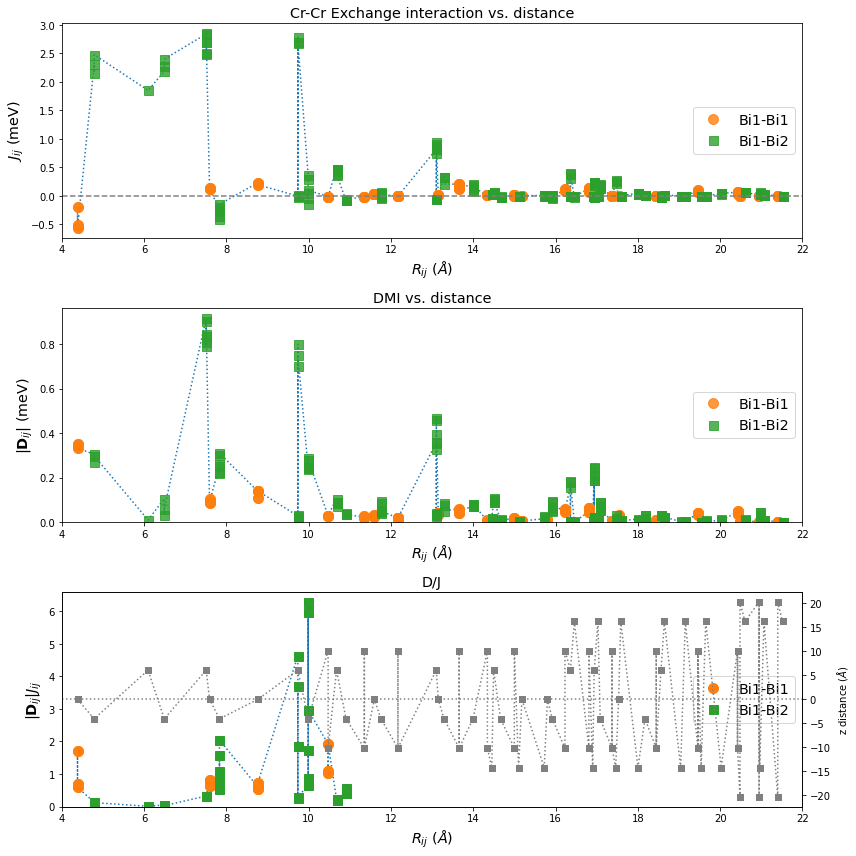

In [18]:
plt.figure(figsize=(12,12))

# plt.subplot(2,1,1)
plt.subplot(3,1,1)
plt.title('Cr-Cr Exchange interaction vs. distance', fontsize='x-large')
#r0 = np.sqrt(np.sum(pos0**2, axis=1))
#plt.plot(r0, jijs0[:,5], 'kd', ms=15, label='smaller k-mesh')
r = np.sqrt(np.sum(pos**2, axis=1))
plt.plot(r, jijs[:,5], ':')
plt.plot(r[jijs[:,1]==10], jijs[jijs[:,1]==10][:,5], 'o', ms=10, alpha=0.8, label='Bi1-Bi1')
plt.plot(r[jijs[:,1]==12], jijs[jijs[:,1]==12][:,5], 's', ms=9, alpha=0.8, label='Bi1-Bi2')
plt.ylabel('$J_{ij}$ (meV)', fontsize='x-large')
plt.axhline(0, ls='--', color='grey')
plt.xlabel('$R_{ij}$ ($\AA$)', fontsize='x-large')
plt.xlim(4, 22)

plt.legend(fontsize='x-large', loc=5)

plt.subplot(3,1,2)
plt.title('DMI vs. distance', fontsize='x-large')
#d0 = np.sqrt(np.sum(jijs0[:,6:9]**2, axis=1))
#plt.plot(r0, d0, 'kd', ms=15, label='smaller k-mesh')
d = np.sqrt(np.sum(jijs[:,6:9]**2, axis=1))
plt.plot(r, d, ':')
plt.plot(r[jijs[:,1]==10], d[jijs[:,1]==10], 'o', ms=10, alpha=0.8, label='Bi1-Bi1')
plt.plot(r[jijs[:,1]==12], d[jijs[:,1]==12], 's', ms=9, alpha=0.8, label='Bi1-Bi2')
plt.ylabel('$|\mathbf{D}_{ij}|$ (meV)', fontsize='x-large')
plt.xlabel('$R_{ij}$ ($\AA$)', fontsize='x-large')
plt.ylim(0)
plt.xlim(4, 22)

plt.legend(fontsize='x-large', loc=5)

plt.subplot(3,1,3)
plt.title('D/J', fontsize='x-large')
mask = np.where(r<=11)
rr, dd, jj = r[mask], d[mask], jijs[mask]
plt.plot(rr, abs(dd/jj[:,5]), ':')
plt.plot(rr[jj[:,1]==10], abs(dd/jj[:,5])[jj[:,1]==10], 'o', ms=10, label='Bi1-Bi1')
plt.plot(rr[jj[:,1]==12], abs(dd/jj[:,5])[jj[:,1]==12], 's', ms=9, label='Bi1-Bi2')
plt.ylabel('$|\mathbf{D}_{ij}|J_{ij}$', fontsize='x-large')
plt.xlabel('$R_{ij}$ ($\AA$)', fontsize='x-large')
plt.ylim(0)
plt.xlim(4, 22)

plt.legend(fontsize='x-large', loc=5)

plt.twinx()
plt.plot(r, (pos[:,2]), 's:', color='grey')
plt.axhline(0, ls=':', color='grey')
plt.ylabel('z distance ($\AA$)')

plt.tight_layout()

plt.show()

In [ ]:
del_node = [105406, 105433]